Analyzing serial neurogym results

In [1]:
#!/usr/bin/env python
# coding: utf-8
# system
import os
import sys
root = os.getcwd()
sys.path.append(root)
sys.path.append('..')
from pathlib import Path
import json
# tools
import time
import itertools
from collections import defaultdict
# computation
import math
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
# tasks
import gym
import neurogym as ngym
from neurogym.wrappers import ScheduleEnvs
from neurogym.utils.scheduler import RandomSchedule
# models
# from model_dev import RNN_MD
# from model_dev import serial_RNN_MD as RNN_MD
# from utils import get_full_performance
# visualization
import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm, trange

# Factorized experiments

In [2]:
experiments = ['same_net', 'random_gates_only', 'train_to_criterion',  'random_gates_no_rehearsal','rehearsal','random_gates',  'correlated_gates', 'cognitive_observer', ]
# folder_name = './../files/factorized/'
folder_name = './../files/final_policy_weaning/'

In [3]:
def get_log_files(data_folder, exp_name, file_sig='testing_log'):
    lfiles = os.listdir(data_folder+f'{exp_name}/')
    lfiles = [fn for fn in lfiles if fn.__contains__(file_sig)]
    logs = []
    for fi, fn in enumerate(lfiles):
        try:
            logs.append(np.load(data_folder+f'{exp_name}/' + fn, allow_pickle=True).item())
        except:
            print('some problem with ', fn)
    return(logs, lfiles)

def convert_train_to_test_idx(training_log, testing_log, training_idx):
    test_idx = training_log.stamps[training_idx]
    diff_arra = np.abs(np.array(testing_log.stamps) - test_idx)
    test_t_idx = np.argmin(diff_arra)
    return(test_t_idx)

In [13]:
exps = ['same_net', 'random_gates_only', 'train_to_criterion', 'random_gates_no_rehearsal' , 'rehearsal','random_gates_mul', ]# 'cognitive_observer', ]
last_task_idx = [14, 14, 14, 14 ,118, 118, ]# 'cognitive_observer', ]
accuracy_dict = {}
total_trials_dict={}
total_optimization_trials_dict={}
optimization_totals_by_reh_len_dict={}
average_acc_dict = {}
for i, exp_name in enumerate(exps):
    testing_logs, test_files = get_log_files(folder_name, exp_name, file_sig='testing_log')
    training_logs, train_files = get_log_files(folder_name, exp_name, file_sig='training_log')
    configs, config_files = get_log_files(folder_name, exp_name, file_sig='config')
    mean_accuracies = []
    totals = []
    optimization_totals = []
    optimization_totals_by_reh_len = defaultdict(list)
    average_acc =[]
    for (testing_log, training_log,config) in (zip(testing_logs, training_logs, configs)):
            ## Get the testing log accuracies for the last trial of training. Getting complicated now there are rehearsal and optimzation trial after it
            # print(f'i is : {i}  len {len(training_log.switch_trialxxbatch)}')
            last_training_trial = training_log.switch_trialxxbatch[last_task_idx[i]] # Getting the time stamp for the last trial of trianing, depending on experiment setup either 14th or 118th task
            last_training_trial_nearest_test_point = convert_train_to_test_idx(training_log, testing_log, last_training_trial)

            final_accuracy_average = np.mean(list(testing_log.accuracies[last_training_trial_nearest_test_point].values()))
            mean_accuracies.append(final_accuracy_average)
            totals.append(last_training_trial)

            # optimization_totals.append(training_log.stamps[-1] - training_log.start_optimizing_at) # total trials spent in optimization
            no_of_optim_tasks = 40
            optim_ttcs = training_log.trials_to_crit[-no_of_optim_tasks:]
            optimization_totals.append(np.mean(optim_ttcs))
            optimization_totals_by_reh_len[config.random_rehearsals].append(np.mean(optim_ttcs))
            # print(config.random_rehearsals)
            # avg
            taa = []
            for logi in range(15):
                taa.append([test_acc[logi] for test_acc in testing_log.accuracies])
            average_acc.append(np.stack(taa))
        
    accuracy_dict.update({exp_name: np.stack(mean_accuracies)})
    total_trials_dict.update({exp_name: np.stack(totals)})
    average_acc_dict.update({exp_name: (average_acc)})
    total_optimization_trials_dict.update({exp_name: (optimization_totals)})
    optimization_totals_by_reh_len_dict.update({exp_name: (optimization_totals_by_reh_len)})

0
0
0
10
5
0
10
5
0
5
0
0
10
5
0
5
0
5
0
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
5
0
10
15
0
10
15
5
0
10
15
5
0
10
15
5


Text(0, 0.5, 'Optimization batches (100 trials)')

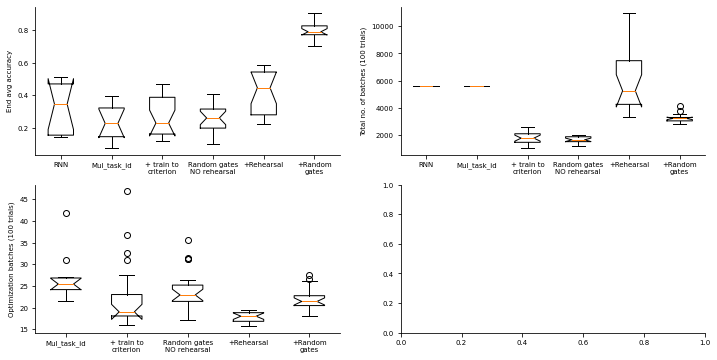

In [10]:
exps_names= ['RNN', 'Mul_task_id', '+ train to\ncriterion', 'Random gates\nNO rehearsal' ,'+Rehearsal', '+Random\ngates', ]# 'cognitive_observer', ]
# exps = ['same_net', , 'train_to_criterion', 'rehearsal','random_gates_no_rehearsal' , 'random_gates_mul', ]# 'cognitive_observer', ]

fig, axes = plt.subplots(2,2, figsize=[12,6])
ax = axes[0,0]
_=ax.boxplot([accuracy_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('End avg accuracy')

ax = axes[0,1]
_=ax.boxplot([total_trials_dict[exp] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')

ax = axes[1,0]
_=ax.boxplot([total_optimization_trials_dict[exp] for exp in exps[1:]], labels=[exp for exp in exps_names[1:]], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Optimization batches (100 trials)')


# plt.savefig('./files/end_accuracy_box_plots.jpg',dpi=300)

Breaking down by number of random rehearsals prior to optim

Text(0, 0.5, 'Optimization batches (100 trials)')

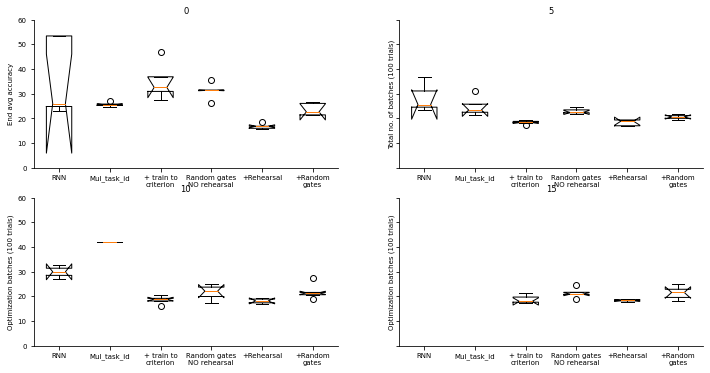

In [19]:
exps_names= ['RNN', 'Mul_task_id', '+ train to\ncriterion', 'Random gates\nNO rehearsal' ,'+Rehearsal', '+Random\ngates', ]# 'cognitive_observer', ]
# exps = ['same_net', , 'train_to_criterion', 'rehearsal','random_gates_no_rehearsal' , 'random_gates_mul', ]# 'cognitive_observer', ]

fig, axes = plt.subplots(2,2, figsize=[12,6], sharey=True)
ax = axes[0,0]
ax.set_title('0')
_=ax.boxplot([optimization_totals_by_reh_len_dict[exp][0] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('End avg accuracy')
ax.set_ylim([0,60])

ax = axes[0,1]
ax.set_title('5')
_=ax.boxplot([optimization_totals_by_reh_len_dict[exp][5] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Total no. of batches (100 trials)')

ax = axes[1,0]
ax.set_title('10')
_=ax.boxplot([optimization_totals_by_reh_len_dict[exp][10] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Optimization batches (100 trials)')

ax = axes[1,1]
ax.set_title('15')
_=ax.boxplot([optimization_totals_by_reh_len_dict[exp][15] for exp in exps], labels=[exp for exp in exps_names], meanline=True, notch=True)
# _=ax.set_xticklabels( exps, rotation=45 )
ax.set_ylabel('Optimization batches (100 trials)')


# plt.savefig('./files/end_accuracy_box_plots.jpg',dpi=300)

average_acc_dict is a dict of keys experiment name. Returns a list of np arrays with accuracies from all tasks. Still need to average them [no_tasks, tstamps]


In [39]:
print(f'started optim: {training_log.start_optimizing_at}')
print(f'last stamp   : {training_log.stamps[-1]}')

started optim: 3612
last stamp   : 4516


0
1
2
3
4
5
6


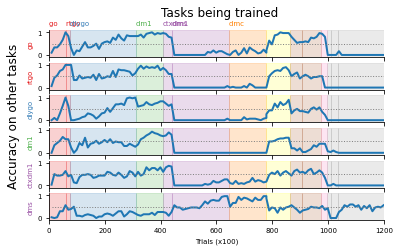

In [11]:
exp_name='train_to_criterion'
logs = get_log_files(folder_name, exp_name, file_sig='testing_log')
configs = get_log_files(folder_name, exp_name, file_sig='config')

testing_log = logs[0]
config = configs[0]
label = exp_name

config.tasks = config.tasks[:6]
no_of_values = 12
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

log = testing_log
log.switch_trialxxbatch.append(log.stamps[-1])
num_tasks = len(config.tasks)
already_seen =[]
title_label = 'Training tasks sequentially ---> \n    ' + config.exp_name
max_x = 1200 #log.stamps[-1] #* config.print_every_batches
fig, axes = plt.subplots(num_tasks,1, figsize=[6,3.5])
for i, (tid, tn) in enumerate(config.tasks_id_name[:num_tasks]):
        ax = axes[ i ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        ax.plot(log.stamps, [test_acc[tid] for test_acc in log.accuracies], linewidth=2)
        ax.plot(log.stamps, np.ones_like(log.stamps)*0.5, ':', color='grey', linewidth=1)
        ax.set_ylabel(tn[7:-3], fontdict={'color': cmap.to_rgba(tid)})
        for ri in range(len(log.switch_trialxxbatch)-1):
                ax.axvspan(log.switch_trialxxbatch[ri], log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(log.switch_task_id[ri]) , alpha=0.2)
        xtl = ax.get_xticklabels()
        if not (i +1== num_tasks):        ax.set_xticklabels([])
for ti, id in enumerate(log.switch_task_id):
    if id not in already_seen:
        if len(already_seen) > num_tasks: break # do not go beyond how many tasks are to be displayed
        already_seen.append(id)
        task_name = config.human_task_names[id]
        print(id)
        task_name = config.human_task_names[id]
        axes[0].text(log.switch_trialxxbatch[ti], 1.3, task_name, color= cmap.to_rgba(id) )
axes[0].text(400, 1.7, 'Tasks being trained', color= 'black', fontsize=12 ,)
axes[4].text(-150, 0., 'Accuracy on other tasks', color= 'black', fontsize=12 ,rotation=90)
axes[-1].set_xlabel('Trials (x100)')
if False:
        gs = np.stack(log.gradients)

        print('gradients shape: ', gs.shape) 
        glabels = ['inp_w', 'inp_b', 'rnn_w', 'rnn_b', 'out_w', 'out_b']
        ax = axes[num_tasks+0]
        gi =2
        ax.plot(log.stamps, gs[:,gi], label= glabels[gi])
        ax.plot(log.stamps, gs[:,gi+1], label= glabels[gi+1])
        ax.set_ylabel('grad_norm')
        ax.legend()
        ax.set_xlim([0, max_x])


plt.savefig('coloredfull.jpg', dpi=300)

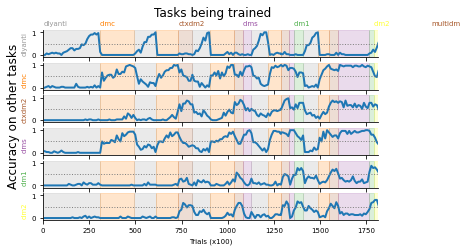

In [31]:
exp_name='rehearsal'
logs, log_files = get_log_files(folder_name, exp_name, file_sig='testing_log')
configs, config_files = get_log_files(folder_name, exp_name, file_sig='config')

log_idx = 4
assert(config_files[log_idx][len('config'):] == log_files[log_idx][len('testing_log'):])
testing_log = logs[log_idx]
config = configs[log_idx]
label = exp_name

config.tasks = config.tasks[:6]
no_of_values = 12
norm = mpl.colors.Normalize(vmin=min([0,no_of_values]), vmax=max([0,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('Set1') # tab20b
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)

log = testing_log
log.switch_trialxxbatch.append(log.stamps[-1])
num_tasks = len(config.tasks)
already_seen =[]
title_label = 'Training tasks sequentially ---> \n    ' + config.exp_name
max_x = log.switch_trialxxbatch[20] #log.stamps[-1] #* config.print_every_batches
fig, axes = plt.subplots(num_tasks,1, figsize=[6,3.5])
for i, (tid, tn) in enumerate(config.tasks_id_name[:num_tasks]):
        ax = axes[ i ] # log i goes to the col direction -->
        ax.set_ylim([-0.1,1.1])
        ax.set_xlim([0, max_x])
#         ax.axis('off')
        ax.plot(log.stamps, [test_acc[tid] for test_acc in log.accuracies], linewidth=2)
        ax.plot(log.stamps, np.ones_like(log.stamps)*0.5, ':', color='grey', linewidth=1)
        ax.set_ylabel(config.human_task_names[tid], fontdict={'color': cmap.to_rgba(tid)})
        for ri in range(len(log.switch_trialxxbatch)-1):
                ax.axvspan(log.switch_trialxxbatch[ri], log.switch_trialxxbatch[ri+1], color =cmap.to_rgba(log.switch_task_id[ri]) , alpha=0.2)
        xtl = ax.get_xticklabels()
        if not (i +1== num_tasks):        ax.set_xticklabels([])
for ti, id in enumerate(log.switch_task_id):
    if id not in already_seen:
        if len(already_seen) > num_tasks: break # do not go beyond how many tasks are to be displayed
        already_seen.append(id)
        task_name = config.human_task_names[id]
        axes[0].text(log.switch_trialxxbatch[ti], 1.3, task_name, color= cmap.to_rgba(id) )
axes[0].text(600, 1.7, 'Tasks being trained', color= 'black', fontsize=12 ,)
axes[4].text(-195, 0., 'Accuracy on other tasks', color= 'black', fontsize=12 ,rotation=90)
axes[-1].set_xlabel('Trials (x100)')
plt.savefig('./files/rehearsal2.jpg', dpi=300)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


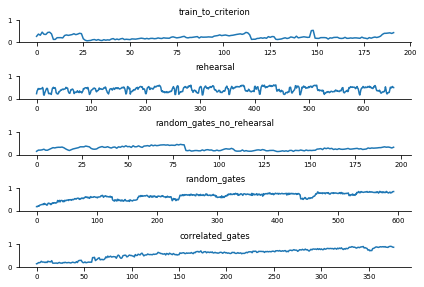

In [7]:
chosen_log = 1
fig, axes = plt.subplots(len(exps), 1, )
for ei, exp in enumerate(exps):
    ax = axes[ei]
    ax.plot(average_acc_dict[exp][chosen_log].mean(0))
    ax.set_ylim([0,1])
    ax.set_title(exp)
fig.tight_layout()

In [8]:
def get_ttc_rehearsals(logs, rehearsal_no):
    rehearsal_data=[]
    for log in logs:
        tstamps = log.switch_trialxxbatch + [log.total_batches]

        counts = np.zeros(15)
        times_seen =[]
        ttcs = []
        for ti, id in enumerate(log.switch_task_id):
            times_seen.append(counts[id])
            ttcs.append(tstamps[ti+1]- tstamps[ti])
            counts[id] +=1
        rehearsal_data.append(np.array(ttcs)[np.array(times_seen)==rehearsal_no])
    return(np.stack(rehearsal_data))


In [10]:
logs = get_log_files(folder_name, 'rehearsal')
def new_get_rehearsals(logs, rehearsal_no=1):

    # print('swtch \ttid \t rehNo \t ttc \t order')
    rehearsal_ttcs = []
    for log in logs:
        times_seen = []
        order_learned = []
        ttc = []
        np_task_id = np.array(log.switch_task_id)
        np_stamps = log.switch_trialxxbatch + [log.total_batches]
        for i in range(len(log.switch_trialxxbatch)):
            times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
            order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
            ttc.append(np_stamps[i+1]- np_stamps[i])
        rehearsal_ttcs.append(np.array(ttc)[np.array(times_seen)==rehearsal_no])
    # for i in (range(12)):
        # print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])
    
    return( np.stack(rehearsal_ttcs) )

rt = new_get_rehearsals(logs, 1)

In [89]:
rt.shape # no_of_seeds, no_of tasks with 1 rehearsal  19, 14


(46, 15)

In [11]:
logs = get_log_files(folder_name, 'rehearsal')
log = logs[0]
print('swtch \ttid \t rehNo \t ttc \t order')
times_seen = []
order_learned = []
ttc = []
np_task_id = np.array(log.switch_task_id)
np_stamps = log.switch_trialxxbatch + [log.total_batches]
for i in range(len(log.switch_trialxxbatch)):
    times_seen.append( np.sum( np_task_id[:i]== log.switch_task_id[i]))
    order_learned.append(np.sum( np.array(times_seen)== times_seen[-1]))
    ttc.append(np_stamps[i+1]- np_stamps[i])

for i in (range(12)):
    print(log.switch_trialxxbatch[i], '\t', log.switch_task_id[i], '\t', times_seen[i], '\t', ttc[i], '\t', order_learned[i])

swtch 	tid 	 rehNo 	 ttc 	 order
0 	 0 	 0 	 58 	 1
58 	 1 	 0 	 14 	 2
72 	 0 	 1 	 11 	 1
83 	 1 	 1 	 11 	 2
94 	 2 	 0 	 68 	 3
162 	 0 	 2 	 12 	 1
174 	 1 	 2 	 11 	 2
185 	 2 	 1 	 67 	 3
252 	 3 	 0 	 70 	 4
322 	 0 	 3 	 12 	 1
334 	 1 	 3 	 11 	 2
345 	 2 	 2 	 66 	 3


In [12]:
ttc_1st_rehearsal_by_learning_order = np.array(ttc)[np.array(times_seen)==2]
print('ttc:', ttc_1st_rehearsal_by_learning_order)
ttc_1st_rehearsal_by_learning_order = np.array(order_learned)[np.array(times_seen)==2]
print('ord:', ttc_1st_rehearsal_by_learning_order)

ttc: [12 11 66 19 39 27 12 30 49 40 21 18 21 78]
ord: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


train_to_criterion


/tmp/ipykernel_38579/2386692087.py:32: RuntimeWarning: Mean of empty slice.
  rehearsal1.update({expn:rehearsal_ttc.mean(1)})
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/tmp/ipykernel_38579/2386692087.py:38: RuntimeWarning: Mean of empty slice.
  rehearsal2.update({expn:rehearsal_ttc.mean(1)})
/om2/user/ahummos/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


rehearsal
random_gates
correlated_gates


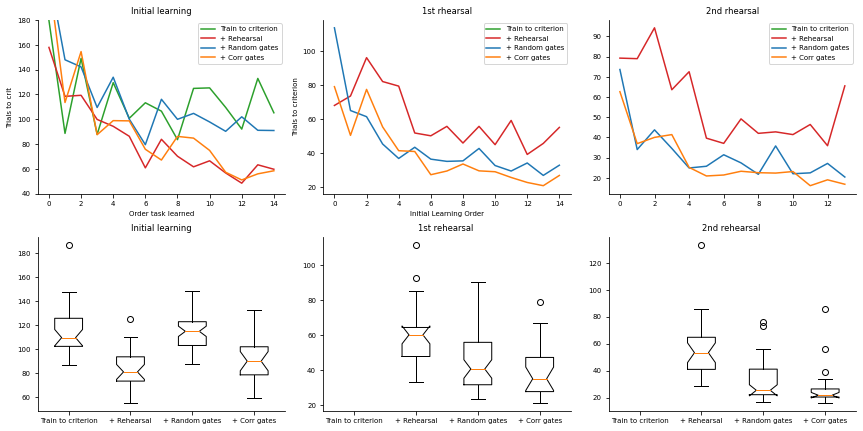

In [14]:
# get all rehearsal orders


rehearsal_total = 14
rehearsal_no = 1
exps_to_plot = [ 'train_to_criterion', 'rehearsal','random_gates',  'correlated_gates',]# 'cognitive_observer', ]
# exps_to_plot = [ 'random_gates',  'correlated_gates',]# 'cognitive_observer', ]
exps_names = [ 'Train to criterion', '+ Rehearsal','+ Random gates',  '+ Corr gates',]# 'cognitive_observer', ]
# exps_names = [ '+ Random gates',  '+ Corr gates',]# 'cognitive_observer', ]
# exps_to_plot = [ 'train_to_criterion', 'rehearsal', ]#'random_gates_no_rehearsal','random_gates',  'correlated_gates',]# 'cognitive_observer', ]
# exps_to_plot = [ 'train_to_criterion',  ]#'random_gates_no_rehearsal','random_gates',  'correlated_gates',]# 'cognitive_observer', ]
initial_learning, rehearsal1, rehearsal2 = {}, {}, {}
colors =['tab:green', 'tab:red', 'tab:blue', 'tab:orange']
fig, axes = plt.subplots(2,3, figsize=([12,6]))
for i, expn in enumerate(exps_to_plot):

    logs = get_log_files(folder_name, expn)
    print(expn)
    ax =axes[0,0]
    rehearsal_ttc = new_get_rehearsals(logs, rehearsal_no=0)  ##########first rehearsal
    ax.plot(rehearsal_ttc.mean(0), label=exps_names[i], color=colors[i])
    ax.set_title('Initial learning')
    initial_learning.update({expn:rehearsal_ttc.mean(1)})
    ax.set_ylabel('Trials to crit')
    ax.set_xlabel('Order task learned')
    ax.set_ylim([40,180])
    
    ax =axes[0,1]
    rehearsal_ttc = new_get_rehearsals(logs, rehearsal_no=1)  ##########first rehearsal
    ax.plot(rehearsal_ttc.mean(0), label=exps_names[i], color=colors[i])
    ax.set_title('1st rhearsal')
    rehearsal1.update({expn:rehearsal_ttc.mean(1)})

    ax = axes[0,2]
    rehearsal_ttc = new_get_rehearsals(logs, rehearsal_no=2) ############second rehearsal
    ax.plot(rehearsal_ttc.mean(0), label=exps_names[i], color=colors[i])
    ax.set_title('2nd rhearsal')
    rehearsal2.update({expn:rehearsal_ttc.mean(1)})

ax =axes[1,0]
_=ax.boxplot([initial_learning[expn] for expn in exps_to_plot], labels= exps_names, notch=True, meanline=True)
ax.set_title('Initial learning')
ax =axes[1,1]
_=ax.boxplot([rehearsal1[expn] for expn in exps_to_plot], labels= exps_names, notch=True, meanline=True)
ax.set_title('1st rehearsal ')
ax =axes[1,2]
_=ax.boxplot([rehearsal2[expn] for expn in exps_to_plot], labels= exps_names, notch=True)
ax.set_title('2nd rehearsal ')

ax = axes[0,0]
ax.legend()
ax = axes[0,2]
ax.legend()
ax = axes[0,1]
ax.legend()
ax.set_xlabel('Initial Learning Order')
ax.set_ylabel('Trials to criterion')
plt.tight_layout()
plt.savefig('rehearsal_new_data.jpg', dpi=300)
